In [ ]:
!pip install torch-geometric
!pip install umap-learn
!pip3 install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 6.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=35b55073d602c08f79c5dfaeea4d1615b8c3e6e419836d05028760e6903ab95e
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


In [ ]:
# Dataset

import torch.nn as nn

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader

import matplotlib.pyplot as plt
import umap
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
import umap.umap_ as umap
import seaborn as sns

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


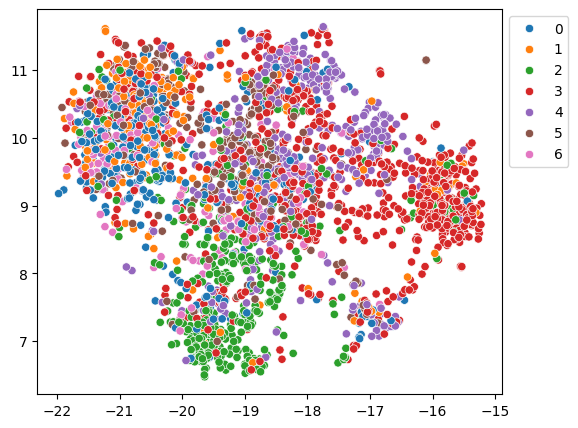

In [ ]:
import umap.umap_ as umap
import seaborn as sns
data_color = []

for y in data.y.numpy():
    data_color.append(f'C{y}')
embd = umap.UMAP().fit_transform(data.x.numpy())

palette = {}
for n, y in enumerate(set(data.y.numpy())):
    palette[y] = f'C{n}'

plt.figure(figsize=(6, 5))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.savefig("umap_raw.png", dpi=120)

In [ ]:
data.edge_index
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph = nx.from_edgelist(edges, create_using=nx.Graph())

In [ ]:
adjacency_matrix = np.zeros((data.x.shape[0], data.x.shape[0]))
for edge in edges:
  src, dst = edge
  adjacency_matrix[src][dst] = 1
  adjacency_matrix[dst][src] = 1


In [ ]:
adjacency_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, pairwise
from sklearn import metrics
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init
import random
from torch import optim

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
  '''
  one-layer GCN
  '''
  def __init__(self, in_feats, n_out):
    super(GCN, self).__init__()
    self.gcn = GCNConv(in_feats, n_out)
    self.activation = nn.PReLU()

  def forward(self, x, a):
    h = self.gcn(x, a)
    out = self.activation(h)

    return out

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

class AFGRL(nn.Module):
  def __init__(self, dataset = data, beta = 0.9, A = adjacency_matrix, in_feats= 1433, n_classes = 7, k = 4, K = 100, M = 5, out_feats = 256, lr = 5e-4, wd = 5e-4, epochs = 10):
    super(AFGRL, self).__init__()
    '''
    AFGRL
    : "Real positive" 찾아서 얘네끼리 가까워지게 만드는 방식

    online network f_theta(GCN) : X -> H_theta / q_theta : H_theta -> z_theta
    target network f_xi(GCN) : X -> H_xi
    k: K-nn

    data.x : torch.Size([2708, 1433])

    H_theat랑 H_xi 얻어서 각각의 representation에서 kNN 뽑기 얘네가 => B (2708, 2 * k)
    '''
    self.lr = lr
    self.wd = wd
    self.dataset = dataset
    self.activation = nn.ReLU()
    self.num_node = dataset.x.shape[0]

    self.k = k
    self.K = K
    self.M = M
    self.beta = beta # for update target network

    self.A = A # adjacency matrix

    self.f_theta = GCN(in_feats, out_feats)
    self.f_xi = GCN(in_feats, out_feats)
    self.q_theta = nn.Linear(out_feats, out_feats)


    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=self.lr)

    self.epochs = epochs

    self.h_theta =torch.zeros((self.num_node, out_feats)) # f_theta 통과해서
    self.h_xi = torch.zeros((self.num_node, out_feats))
    self.z_theta = torch.zeros((self.num_node, out_feats))
    self.B = {i: [] for i in range(dataset.x.shape[0])} # B 저장 각각 k개씩
    self.P = {i: [] for i in range(dataset.x.shape[0])} # Real Positive 넣을 곳

    self.labels = None


  def similarity(self, i, j):
    sm = torch.dot(self.h_theta[i], self.h_xi[j]) / torch.norm(self.h_theta[i]) / torch.norm(self.h_xi[j])
    return sm

  def encode(self, X):
    self.h_theta = self.f_theta(X, self.dataset.edge_index)
    self.h_xi = self.f_xi(X, self.dataset.edge_index).detach() # stop gradient at target network

  def search_knn(self):
    '''
    Bi
    search for knn in representation space
    '''
    # 이거 너무 오래 걸려!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # for node in range(self.num_node):
    #   node_similarities = [(other_node, self.similarity(node, other_node)) for other_node in range(self.num_node) if other_node != node]
    #   sorted_similarities = sorted(node_similarities, key=lambda x: x[1], reverse=True)
    #   knn_list = [node_idx for node_idx, _ in sorted_similarities[:self.k]]
    #   for nn in knn_list:
    #     if nn not in self.B[node]:
    #       self.B[node].append(nn)
    h_theta_norm = torch.norm(self.h_theta, dim=1)
    h_xi_norm = torch.norm(self.h_xi, dim=1)
    similarities = torch.mm(self.h_theta, self.h_xi.T) / (h_theta_norm.unsqueeze(1) * h_xi_norm.unsqueeze(0))
    similarities.fill_diagonal_(0)
    _, knn_indices = torch.topk(similarities, self.k, dim=1)

    for node, knn_list in enumerate(knn_indices):
      for nn in knn_list:
        if nn.item() not in self.B[node]:
          self.B[node].append(nn.item())



  def local_positives(self):
    '''
    Ni
    adjacency neighbors && Bi
    '''
    for node in range(self.num_node):
      for b in self.B[node]:
        if self.A[node][b] and b not in self.P[node]:
          self.P[node].append(b) # add Real positive

  def KMeans(self):
    '''
    target network의 representation에서 KMeanse clustering 진행
    => Global perpective 반영하기 위함
    '''
    data = self.h_xi.detach().numpy()
    kmeans = KMeans(n_clusters= self.K, n_init=10)
    kmeans.fit(data)
    cluster_centers = torch.tensor(kmeans.cluster_centers_)
    self.labels = torch.tensor(kmeans.labels_) # (idx, label)


  def global_positives(self):
    '''
    Ci
    '''
    self.KMeans()
    for node in range(self.num_node):
      for b in self.B[node]:
        if self.labels[b] == self.labels[node] and b not in self.P[node]:
          self.P[node].append(b)

  def predict(self):
    self.z_theta =  self.q_theta(self.h_theta)

  def forward(self):
    self.encode(self.dataset.x) # encoder 통과
    self.search_knn() # B 완성
    self.local_positives()
    self.global_positives()
    # We got self.P : Real positives
    self.predict()
    loss1 = 0
    loss2 = 0
    for node in range(self.num_node):
      for real_positive in self.P[node]:
        cosine_distance1 = self.similarity(node, real_positive)
        cosine_distance2 = self.similarity(real_positive, node) # symmerize the loss function
        loss2 += cosine_distance2
        loss1 += cosine_distance1
    loss = (loss1 + loss2) / self.num_node
    loss /= 2

    # for 문 돌리는 것보다 matrix 연산으로 하는 게 더 좋을듯!
    return -loss

  def fit(self):
    self.train()
    for epoch in range(self.epochs):
      total_loss = []
      self.optimizer.zero_grad()
      loss = self()
      loss.backward()
      self.optimizer.step()
      theta_params = self.f_theta.parameters()
      xi_params = self.f_xi.parameters()

      # xi parameter들은 theta parameter로 가중평균 업데이트 (BYOL처럼)
      weighted_params = []
      for theta_param, xi_param in zip(theta_params, xi_params):
        weighted_param = (1 - self.beta) * theta_param + self.beta * xi_param
        weighted_params.append(weighted_param)

      with torch.no_grad():
        for xi_param, weighted_param in zip(xi_params, weighted_params):
          xi_param.copy_(weighted_param)

      if epoch % 5 == 0:
        print(f'Epoch {epoch:>2} | Train Loss: {loss:.3f}')


model = AFGRL(lr = 1e-3, wd = 5e-4, epochs = 30)
print(model)
# Train
model.fit()


AFGRL(
  (activation): ReLU()
  (f_theta): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (f_xi): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (q_theta): Linear(in_features=256, out_features=256, bias=True)
)
Epoch  0 | Train Loss: -0.031
Epoch  5 | Train Loss: -0.347
Epoch 10 | Train Loss: -0.684
Epoch 15 | Train Loss: -0.940
Epoch 20 | Train Loss: -1.169
Epoch 25 | Train Loss: -1.349


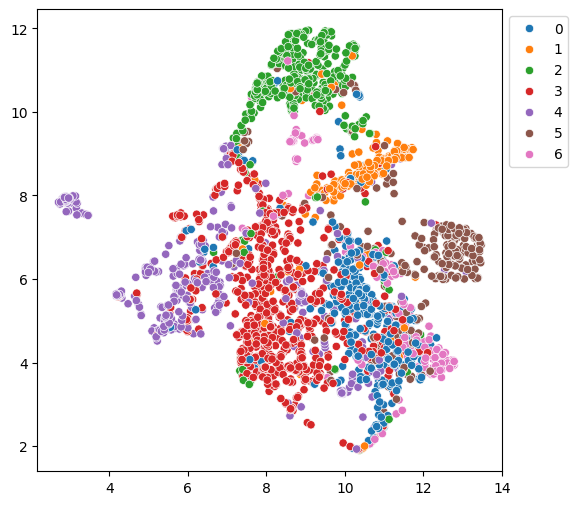

In [ ]:
out_numpy = model.h_theta.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

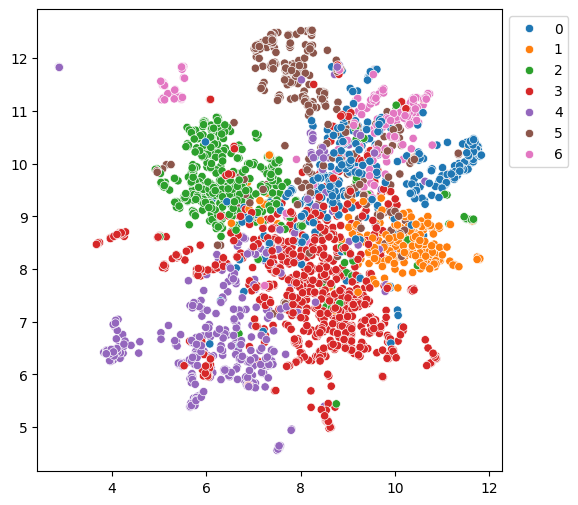

In [ ]:
out_numpy = model.h_xi.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

헐 진짜 됨!!!!!!!!!!!!!!!!!!!!!

# Target network에 Stop Gradient 안한 경우

In [ ]:
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
  '''
  one-layer GCN
  '''
  def __init__(self, in_feats, n_out):
    super(GCN, self).__init__()
    self.gcn = GCNConv(in_feats, n_out)
    self.activation = nn.PReLU()

  def forward(self, x, a):
    h = self.gcn(x, a)
    out = self.activation(h)

    return out

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

class AFGRL(nn.Module):
  def __init__(self, dataset = data, beta = 0.9, A = adjacency_matrix, in_feats= 1433, n_classes = 7, k = 4, K = 100, M = 5, out_feats = 256, lr = 5e-4, wd = 5e-4, epochs = 10):
    super(AFGRL, self).__init__()
    '''
    AFGRL
    : "Real positive" 찾아서 얘네끼리 가까워지게 만드는 방식

    online network f_theta(GCN) : X -> H_theta / q_theta : H_theta -> z_theta
    target network f_xi(GCN) : X -> H_xi
    k: K-nn

    data.x : torch.Size([2708, 1433])

    H_theat랑 H_xi 얻어서 각각의 representation에서 kNN 뽑기 얘네가 => B (2708, 2 * k)
    '''
    self.lr = lr
    self.wd = wd
    self.dataset = dataset
    self.activation = nn.ReLU()
    self.num_node = dataset.x.shape[0]

    self.k = k
    self.K = K
    self.M = M
    self.beta = beta # for update target network

    self.A = A # adjacency matrix

    self.f_theta = GCN(in_feats, out_feats)
    self.f_xi = GCN(in_feats, out_feats)
    self.q_theta = nn.Linear(out_feats, out_feats)


    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=self.lr)

    self.epochs = epochs

    self.h_theta =torch.zeros((self.num_node, out_feats)) # f_theta 통과해서
    self.h_xi = torch.zeros((self.num_node, out_feats))
    self.z_theta = torch.zeros((self.num_node, out_feats))
    self.B = {i: [] for i in range(dataset.x.shape[0])} # B 저장 각각 k개씩
    self.P = {i: [] for i in range(dataset.x.shape[0])} # Real Positive 넣을 곳

    self.labels = None


  def similarity(self, i, j):
    sm = torch.dot(self.h_theta[i], self.h_xi[j]) / torch.norm(self.h_theta[i]) / torch.norm(self.h_xi[j])
    return sm

  def encode(self, X):
    self.h_theta = self.f_theta(X, self.dataset.edge_index)
    self.h_xi = self.f_xi(X, self.dataset.edge_index)

  def search_knn(self):
    '''
    Bi
    search for knn in representation space
    '''

    h_theta_norm = torch.norm(self.h_theta, dim=1)
    h_xi_norm = torch.norm(self.h_xi, dim=1)
    similarities = torch.mm(self.h_theta, self.h_xi.T) / (h_theta_norm.unsqueeze(1) * h_xi_norm.unsqueeze(0))
    similarities.fill_diagonal_(0)
    _, knn_indices = torch.topk(similarities, self.k, dim=1)

    for node, knn_list in enumerate(knn_indices):
      for nn in knn_list:
        if nn.item() not in self.B[node]:
          self.B[node].append(nn.item())



  def local_positives(self):
    '''
    Ni
    adjacency neighbors && Bi
    '''
    for node in range(self.num_node):
      for b in self.B[node]:
        if self.A[node][b] and b not in self.P[node]:
          self.P[node].append(b) # add Real positive

  def KMeans(self):
    '''
    target network의 representation에서 KMeanse clustering 진행
    => Global perpective 반영하기 위함
    '''
    data = self.h_xi.detach().numpy()
    kmeans = KMeans(n_clusters= self.K, n_init = 10)
    kmeans.fit(data)
    cluster_centers = torch.tensor(kmeans.cluster_centers_)
    self.labels = torch.tensor(kmeans.labels_) # (idx, label)


  def global_positives(self):
    '''
    Ci
    '''
    self.KMeans()
    for node in range(self.num_node):
      for b in self.B[node]:
        if self.labels[b] == self.labels[node] and b not in self.P[node]:
          self.P[node].append(b)

  def predict(self):
    self.z_theta =  self.q_theta(self.h_theta)

  def forward(self):
    self.encode(self.dataset.x) # encoder 통과
    self.search_knn() # B 완성
    self.local_positives()
    self.global_positives()
    # We got self.P : Real positives
    self.predict()
    loss1 = 0
    loss2 = 0
    for node in range(self.num_node):
      for real_positive in self.P[node]:
        cosine_distance1 = self.similarity(node, real_positive)
        cosine_distance2 = self.similarity(real_positive, node) # symmerize the loss function
        loss2 += cosine_distance2
        loss1 += cosine_distance1
    loss = (loss1 + loss2) / self.num_node
    loss /= 2

    # for 문 돌리는 것보다 matrix 연산으로 하는 게 더 좋을듯!
    return -loss

  def fit(self):
    self.train()
    for epoch in range(self.epochs):
      total_loss = []
      self.optimizer.zero_grad()
      loss = self()
      loss.backward()
      self.optimizer.step()
      theta_params = self.f_theta.parameters()
      xi_params = self.f_xi.parameters()

      if epoch % 5 == 0:
        print(f'Epoch {epoch:>2} | Train Loss: {loss:.3f}')


model = AFGRL(lr = 1e-3, wd = 5e-4, epochs = 30)
print(model)
# Train
model.fit()


AFGRL(
  (activation): ReLU()
  (f_theta): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (f_xi): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (q_theta): Linear(in_features=256, out_features=256, bias=True)
)
Epoch  0 | Train Loss: -0.036
Epoch  5 | Train Loss: -0.571
Epoch 10 | Train Loss: -1.051
Epoch 15 | Train Loss: -1.411
Epoch 20 | Train Loss: -1.637
Epoch 25 | Train Loss: -1.810


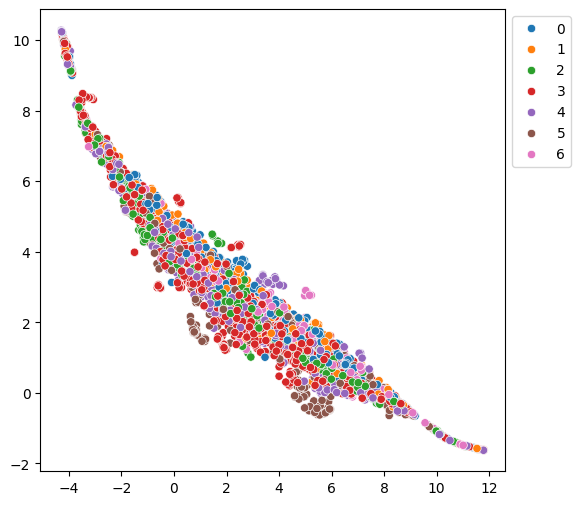

In [ ]:
out_numpy = model.h_theta.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

AFGRL(
  (activation): ReLU()
  (f_theta): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (f_xi): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (q_theta): Linear(in_features=256, out_features=256, bias=True)
)
Epoch  0 | Train Loss: -0.032
Epoch  5 | Train Loss: -0.546


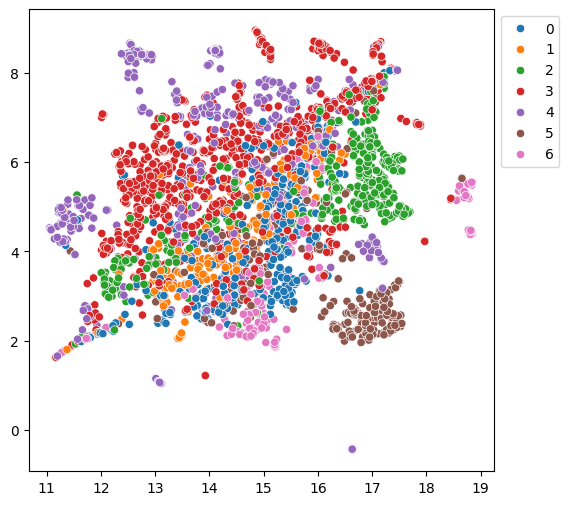

In [ ]:
model = AFGRL(lr = 1e-3, wd = 5e-4, epochs = 20)
print(model)
# Train
model.fit()
out_numpy = model.h_theta.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

AFGRL(
  (activation): ReLU()
  (f_theta): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (f_xi): GCN(
    (gcn): GCNConv(1433, 256)
    (activation): PReLU(num_parameters=1)
  )
  (q_theta): Linear(in_features=256, out_features=256, bias=True)
)
Epoch  0 | Train Loss: -0.036
Epoch  5 | Train Loss: -0.558
Epoch 10 | Train Loss: -0.986
Epoch 15 | Train Loss: -1.386


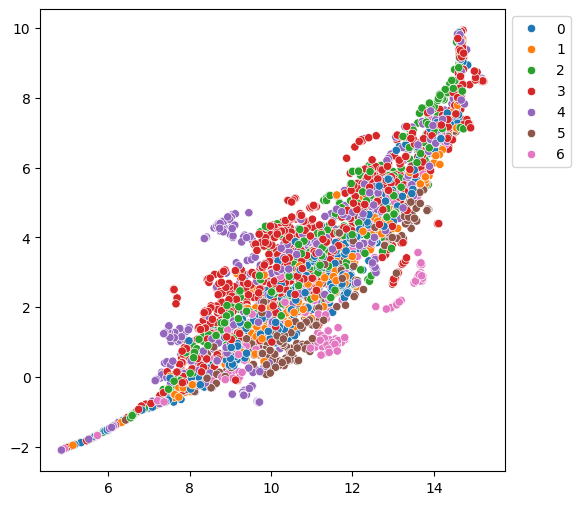

In [ ]:
model = AFGRL(lr = 1e-3, wd = 5e-4, epochs = 20)
print(model)
# Train
model.fit()
out_numpy = model.h_theta.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')